# 4_SPHEREx_Simulate_LVF_Image
# Simulate LVF images using what we have learned from the class
- Prerequisites
    - Convolution (FFT vs real-space)
    - Sampling
    - WCS
- For a given (ra, dec, SED) of a point source, simulate an LVF image
- Demo: SPHEREx-Sky-Simulator

## Authors
- Yujin Yang, Woong-Seob Jeong (KASI SPHEREx Team)

<div class="alert alert-block alert-danger">
    <span style='font-size:18px'>
    The numbers in this notebook is for approximation only to illustrate SPHEREx LVF images
    </span>    
</div>

## <span style='color:DarkSlateBlue'> Components </span>

### Survey Plan (out of the scope of this class)
- Time of observation: when?
- What sequence?
- Orientation?
- We will simulate one pointing with arbitrary date & orientation

### Source
- Position, SED, shape & size
- Sky background: Zodi

### Instrument
- LVF bands
- PSF
- Efficiency: count rates

## <span style='color:DarkSlateBlue'> Setting for this notebook </span>
- conda install `scikit-image`

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.integrate import trapezoid
from skimage.transform import downscale_local_mean

from astropy import units as u
from astropy.table import Table

from astropy.io import fits
from astropy import wcs

from astropy.coordinates import SkyCoord
from astropy.modeling.models import Gaussian1D
from astropy.convolution import Gaussian2DKernel

mpl.rcParams["axes.titlesize"] = 13
mpl.rcParams["axes.labelsize"] = 15

In [3]:
# Constants
c_ums = 3e14                  # c in um/s
c = 3e8                       # m/s
h = 6.626e-34                 # Planck constant   [J/Hz]
k = 1.38e-23                  # Boltzman constant [J/K]
rad2arcsec = (180/np.pi*3600) # 206265 arcsec
arcsec2rad = 1/rad2arcsec

## <span style='color:DarkSlateBlue'> Structure / API </span>

```python
# Setup SPHEREx pointing 
# Create high-resolution FITS image
highres_image, highres_wcs = spherex_highres_image(pointing, bandinfo=bandinfo)

# Load sources for a given pointing
source[ra, dec, wave, flux] = load_catalog(highres_wcs)

# Add sources
for source in source_list:
    add_source(ra, dec, wave, flux):
        # position on detector
        xpos, ypos = get_pixel_coordinates(ra, dec, highres_wcs, bandinfo=bandinfo)
        # LVF
        wave_lvf, trans_lvf = get_lvf_trans(xpos, ypos, bandinfo=bandinfo)
        # Count rate
        I_photo = count_rate(wave, flux, wave_lvf, trans_lvf, bandinfo=bandinfo) 
        highres_image[xpos, ypos] = I_photo
    
# Downsample highres_image to SPHEREx LVF image
image, wcs = downsample(highres_image, highres_wcs)

# Add diffuse background
image_zodi = add_zodi(image, jd=24153.0, bandinfo=bandinfo)

# Simulate instrumental effect + noises
apply_instrument(image, bandinfo=bandinfo)

# Save data
```

## <span style='color:DarkSlateBlue'> SPHEREx band definition: `dict: bandinfo` </span>

In [4]:
# Key SPHEREx Parameters

lambda_min = np.array([0.75, 1.11, 1.64, 2.42, 3.82, 4.42])
lambda_max = np.array([1.11, 1.64, 2.42, 3.82, 4.42, 5.00])
resolving_power = np.array([ 41, 41, 41, 35, 110, 130])
    
eff_mirrors_Au = (0.965)**3   # Gold coating, 3 mirrors
eff_dichroic = 0.98           # splitter
eff_fpa = 0.75                # Detector Quantum Efficiency (QE)
eff_LVF = np.array([0.97, 0.97, 0.88, 0.86, 0.78, 0.72])  # LVF peak transmission

eff_opt   = eff_mirrors_Au * eff_dichroic * eff_LVF
eff_total = eff_opt * eff_fpa

pixel_sr = (6.2*arcsec2rad)**2
AOmega = np.pi * (0.2/2)**2 * pixel_sr

# Choose a band and carry all information with a bandinfo dictionary
band = 1

bandinfo = {
    'band': band,
    'lmin': lambda_min[band-1],
    'lmax': lambda_max[band-1],
    'R': resolving_power[band-1],
    'eff_LVF': eff_opt[band-1],
    'eff_total': eff_total[band-1],
}
bandinfo

{'band': 1,
 'lmin': 0.75,
 'lmax': 1.11,
 'R': 41,
 'eff_LVF': 0.8542396980249999,
 'eff_total': 0.6406797735187499}

## 1. Create empty high-resolution image
- high-resolution image = oversampled SPHEREx image
- typical oversample factor = 5 (i.e., 6.2 arcsec = 5 pixels)
- Use DS9 to check highres.fits

In [5]:
def spherex_highres_image(ra, dec, oversample=5, pixel_size=6.2, 
                          nx=2048, ny=2048, savefile=None):

    # Create a new WCS object.
    # WCS = World Coordinate System
    w = wcs.WCS(naxis=2)         # number of axes
    w.wcs.crval = [ra, dec]      # reference point (ra, dec)
    w.wcs.crpix = [nx*oversample/2, ny*oversample/2]         # reference pixel (xp, yp)
    w.wcs.cdelt = np.array([-pixel_size/oversample/3600.0,   # pixel scale
                             pixel_size/oversample/3600.0])

    w.wcs.ctype = ["RA---SIN", "DEC--SIN"]  # WCS projection type
    w.wcs.crota = [0.0, 0.0]                # zero roll angle / rotation

    # Create FITS image 
    header = w.to_header()                         # astropy.io.fits.Header
    im = np.zeros((ny*oversample, nx*oversample))  # note (ny, nx) instead of (nx, ny)
    hdu = fits.PrimaryHDU(im, header=header)

    # Save to FITS file
    if savefile is not None:
        hdu.writeto(savefile, overwrite=True)
    
    return im, w

In [6]:
# Test spherex_highres_image
# ra_center, dec_center = 0., 90.
ra_center, dec_center = 0.0, 0.0
oversample = 5
highres_image, highres_wcs = spherex_highres_image(ra_center, dec_center, oversample=oversample, 
                                                   savefile='highres.fits', nx=1024)
highres_wcs.to_header()

WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =               2560.0 / Pixel coordinate of reference point            
CRPIX2  =               5120.0 / Pixel coordinate of reference point            
CDELT1  = -0.00034444444444444 / [deg] Coordinate increment at reference point  
CDELT2  =  0.00034444444444444 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CTYPE1  = 'RA---SIN'           / Right ascension, orthographic/synthesis project
CTYPE2  = 'DEC--SIN'           / Declination, orthographic/synthesis projection 
CRVAL1  =                  0.0 / [deg] Coordinate value at reference point      
CRVAL2  =                  0.0 / [deg] Coordinate value at reference point      
LONPOLE =                180.0 / [deg] Native longitude of celestial pole       
LATPOLE =                  0

## 2. Load source list and SEDs
- Find sources within the given SPHEREx pointing
- Load SED information
- Here, we use a catalog file from EL-COSMOS: `data/ELCOSMOS_v1.part.fits`

In [7]:
def load_catalog(highres_wcs):
    filename = '../data/ELCOSMOS_v1.part.fits'
    T = Table.read(filename)
    return T

def get_sed(sedfile):
    path = '../data/ELCOSMOS/'
    T = Table.read(path+sedfile)
    
    wl = T['wavelength'] # angstrom
    f_lambda = T['flux'] # erg/s/cm2/A

    # conversion to f_nu
    f_nu = f_lambda * wl * (wl / 2.99792e18) / (1e-23 * 1e-6)  # micro Jansky
    wl = wl / 10000      # micron

    # Fix the input SED table
    remove_duplicate_in_spec(wl, f_nu)
   
    return wl, f_nu

# To remove duplicate entries in the EL COSMOS SED table. 
from spherex_helper import remove_duplicate_in_spec

ID,ra,dec,ZPHOT,i_HSC,zone,sedfile
,deg,deg,,mag,,
int32,float64,float64,float32,float32,int64,bytes15
460674,150.5468895443,2.0216261104,0.0203,16.1678,4,sed_460674.fits
426043,149.4444273563,1.9397076966,0.2723,19.2476,9,sed_426043.fits
434152,150.2075935599,1.951848484,0.3561,19.7883,8,sed_434152.fits
358577,149.474646478,1.8314245532,0.5888,20.1266,9,sed_358577.fits
673633,150.6309253915,2.3200427849,0.2295,20.3773,4,sed_673633.fits
902734,149.8412185038,2.6681716694,0.22,20.5833,3,sed_902734.fits
...,...,...,...,...,...,...
651276,149.7944444079,2.2873792027,1.1154,23.8933,6,sed_651276.fits


(150.068902821032, 2.205734584026)

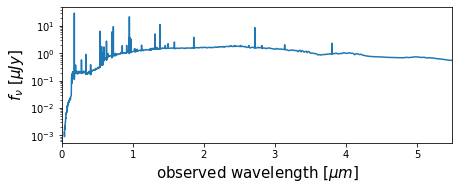

In [8]:
# Test load_catalog
T = load_catalog(highres_wcs)
T

T['ra'].mean(), T['dec'].mean()

for r in T:
    sedfile = r['sedfile']    
    wave, flux = get_sed(sedfile)

# Plot SED for last entry
_ = plt.figure(figsize=(7,2.5))
_ = plt.plot(wave, flux)
_ = plt.xlabel(r'observed wavelength [$\mu m$]')
_ = plt.ylabel(r'$f_{\nu}$ [$\mu Jy$]')
_ = plt.yscale('log')
_ = plt.xlim(0.0, 5.5)

## 3. Inject sources
- Position on the detector
- LVF transmission
- Count rates of the sources
- Diffuse background

### Find where the source is located in the detector

In [9]:
def get_pixel_coordinates(ra, dec, highres_wcs):
    """
    Retruns the detector (x,y) position for a (ra,dec) & WCS
    """
    sky = SkyCoord(ra*u.deg, dec*u.deg)
    xpos, ypos = highres_wcs.world_to_pixel(sky)
    return xpos, ypos

In [10]:
# Test get_pixel_coordinates
xpos, ypos = get_pixel_coordinates(0, 0, highres_wcs)
print(xpos, ypos)
print(xpos/oversample, ypos/oversample)

2559.0 5119.0
511.8 1023.8


### Find the LVF transmission

In [11]:
def get_ichan(xpix, ypix, nx=2048, ny=2048):
    """
    Returns channel number for detector xpix, ypix
    """
    Nchan = 16.0
    
    assert np.max(xpix) < nx
    assert np.max(ypix) < ny
    
    return Nchan / ny * ypix - 0.5

def get_lvf_trans(xpix, ypix, bandinfo=None):
    """
    xpix = coordinate in SPHEREx image (not oversampled)
    ypix = coordinate in SPHEREx image (not oversampled)
    ----
    Returns LVF transmission for a given pixel
    """
    lmin = bandinfo['lmin']
    R = bandinfo['R']

    # get the central wavelenth
    wcen = lmin * ( (2*R+1)/(2*R-1) )**get_ichan(xpix, ypix)
    fwhm = wcen / R
    
    prof = Gaussian1D(amplitude=1, mean=wcen, stddev=fwhm/2.35)
    
    # wavelenth vector
    wl_lvf = np.linspace(wcen-fwhm*3, wcen+fwhm*3, 200)
    tr_lvf = prof(wl_lvf)
    
    return wl_lvf, tr_lvf

def get_wavemap(bandinfo=None, nx=2048, ny=2048):
    """
    Returns the central wavelength map
    """
    xv = np.arange(nx)
    yv = np.arange(ny)

    xx, yy = np.meshgrid(xv, yv, indexing='xy')

    lmin = bandinfo['lmin']
    R = bandinfo['R']
    return lmin * ( (2*R+1)/(2*R-1) )**get_ichan(xx,yy)   

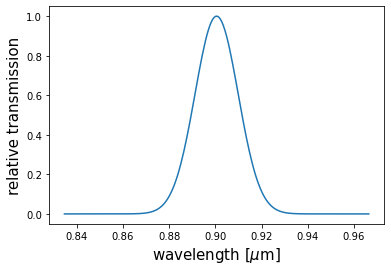

In [12]:
# Test get_lvf_trans
xpix, ypix = xpos/oversample, ypos/oversample
wave_lvf, trans_lvf = get_lvf_trans(xpix, ypix, bandinfo=bandinfo)
_ = plt.plot(wave_lvf, trans_lvf)
_ = plt.xlabel('wavelength [$\mu$m]')
_ = plt.ylabel('relative transmission')

### Estimate count rates [electrons/s] from the sources (flux-density to photo-current)

In [13]:
from spherex_helper import synth_phot

In [14]:
def get_countrate_for_fnu(fnu, bandinfo=None):
    """
    Convert flux density (Jy) to photo-current (e/s)
    """
    R = bandinfo['R']
    eff_total = bandinfo['eff_total']
    
    A = np.pi * (0.2/2)**2
    Jy_to_e_per_s = A * eff_total / R / 6.62607e-34 * 1e-26
    I_photo = fnu * Jy_to_e_per_s
    
    return I_photo * (u.electron / u.s)

In [15]:
fnu_src = 1e-3
get_countrate_for_fnu(fnu_src, bandinfo=bandinfo)

<Quantity 7.40885354 electron / s>

In [16]:
fnu_src * 1e-23

1e-26

### Estimate count rates [electrons/s] from sky background (SB to photo-current)

In [17]:
from spherex_helper import nuInu_ZL

In [18]:
def get_countrate_for_nuInu(nuInu, lambda_um, bandinfo=None):
    """
    Convert nuInu [nW/m2/sr] to photo-current (e/s)
    """
    
    R = bandinfo['R']
    eff_total = bandinfo['eff_total']
    
    I_photo = 1e-9 * nuInu*AOmega*eff_total/(R*h*c_ums/lambda_um)  # [e/s]
    return I_photo * (u.electron / u.s)  

In [19]:
get_countrate_for_nuInu(nuInu_ZL(0.93), 0.93, bandinfo=bandinfo)

<Quantity 1.10796401 electron / s>

### Inject the sources into the highres image [e/s] as a point source

(2559, 5119)

(10240, 5120)

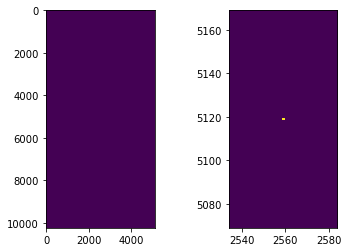

In [20]:
xpos_int, ypos_int = map(int, (xpos, ypos))

highres_image <<= u.electron / u.s
highres_image[ypos_int, xpos_int] = get_countrate_for_fnu(fnu_src, bandinfo=bandinfo)

xpos_int, ypos_int
highres_image.shape

fig, ax = plt.subplots(1,2)

_ = ax[0].imshow(highres_image.data)

_ = ax[1].imshow(highres_image.data, interpolation='none')
_ = ax[1].set_xlim(xpos_int-25, xpos_int+25)
_ = ax[1].set_ylim(ypos_int-50, ypos_int+50)

### Add diffuse background (Zodi) to SPHEREx image [e/s]


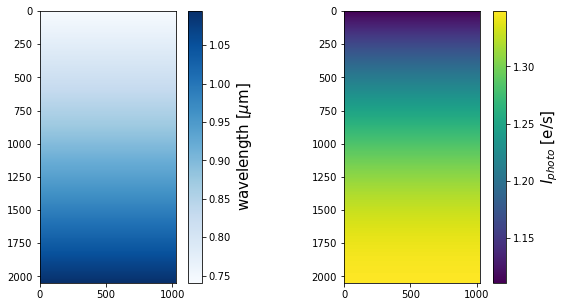

In [21]:
# Create background count rates for SPHEREx naive image (not-oversampled)
wavemap = get_wavemap(nx=1024, bandinfo=bandinfo)
nuInu_zodi = nuInu_ZL(wavemap, f_ZL=2.0)
image_zodi = get_countrate_for_nuInu(nuInu_zodi, wavemap, bandinfo=bandinfo)

# Wavelenth map
fig, ax = plt.subplots(1,2, figsize=(10,5))
im0 = ax[0].imshow(wavemap, cmap='Blues')
plt.colorbar(im0, ax=ax[0], label='wavelength [$\mu$m]')

# Zodi background
im1 = ax[1].imshow(image_zodi.data)
plt.colorbar(im1, ax=ax[1], label='$I_{photo}$ [e/s]')

## 4. Apply Instrument
- T(int) = 150s
- PSF convolution
- Add read noise
- Add photon noise

### Convolve PSF with the highres source image

In [22]:
def get_psf(wavelength_um, oversample=5):
    wl = wavelength_um
    
    D = 20.            # cm
    WFE = 0.25         # um
    rms_pointing = 1.0 # arcsec

    fwhm_diffraction = 1.22*wl/(D*1e4) * rad2arcsec
    fwhm_wfe = fwhm_diffraction * np.sqrt(np.exp((2*np.pi*WFE/wl)**2))
    fwhm_jitter = rms_pointing * 2.35
    fwhm_final = np.sqrt(fwhm_wfe**2 + fwhm_jitter**2)   
    
    pixscale_oversampled = 6.2/oversample
    fwhm_pixel = fwhm_final / pixscale_oversampled

    psf = Gaussian2DKernel(fwhm_pixel / 2.35)
    return psf

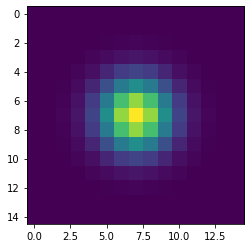

In [23]:
# Test get_psf
kernel = get_psf(1.0)
plt.imshow(get_psf(1.0))

In [24]:
from scipy.signal import fftconvolve
highres_image_conv = fftconvolve(highres_image, kernel, mode='same')

In [25]:
# Check flux conservation
highres_image.sum()
highres_image_conv.sum()

<Quantity 7.40885354 electron / s>

7.408755995408416

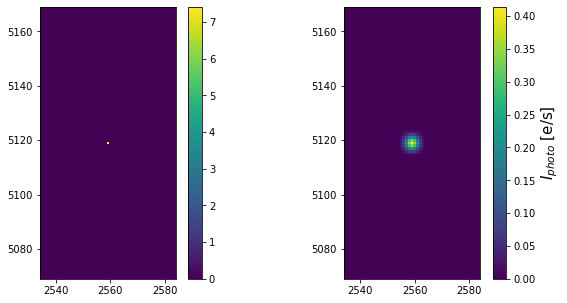

In [26]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

im0 = ax[0].imshow(highres_image.data, interpolation='none')
_ = ax[0].set_xlim(xpos_int-25, xpos_int+25)
_ = ax[0].set_ylim(ypos_int-50, ypos_int+50)
plt.colorbar(im0, ax=ax[0])

im1 = ax[1].imshow(highres_image_conv.data, interpolation='none')
_ = ax[1].set_xlim(xpos_int-25, xpos_int+25)
_ = ax[1].set_ylim(ypos_int-50, ypos_int+50)
plt.colorbar(im1, ax=ax[1], label='$I_{photo}$ [e/s]')

In [27]:
# Save image to FITS and inspect with DS9
header = highres_wcs.to_header()
hdu = fits.PrimaryHDU(highres_image_conv, header=header)
hdu.writeto('highres_src.fits', overwrite=True)

### Downsample to SPHEREx resolution

In [28]:
def downsample(highres_image_conv, highres_wcs, oversample=5):
    # image
    spherex_image = downscale_local_mean(highres_image_conv.data, (oversample, oversample))
    spherex_image *= oversample**2

    # wcs
    spherex_wcs = highres_wcs.copy()
    spherex_wcs.wcs.crpix = [x / oversample for x in highres_wcs.wcs.crpix]
    spherex_wcs.wcs.cdelt = [x * oversample for x in highres_wcs.wcs.cdelt]
    
    return spherex_image, spherex_wcs    

In [29]:
# Test
spherex_image, spherex_wcs = downsample(highres_image_conv, highres_wcs)
spherex_wcs.to_header()

WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =                512.0 / Pixel coordinate of reference point            
CRPIX2  =               1024.0 / Pixel coordinate of reference point            
CDELT1  =  -0.0017222222222222 / [deg] Coordinate increment at reference point  
CDELT2  =   0.0017222222222222 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CTYPE1  = 'RA---SIN'           / Right ascension, orthographic/synthesis project
CTYPE2  = 'DEC--SIN'           / Declination, orthographic/synthesis projection 
CRVAL1  =                  0.0 / [deg] Coordinate value at reference point      
CRVAL2  =                  0.0 / [deg] Coordinate value at reference point      
LONPOLE =                180.0 / [deg] Native longitude of celestial pole       
LATPOLE =                  0

In [30]:
spherex_image.shape
oversample

highres_image.sum()
highres_image_conv.sum()
spherex_image.sum()

(2048, 1024)

5

<Quantity 7.40885354 electron / s>

7.408755995408416

7.408755995408417

### Add sky background (Zodi)

In [31]:
spherex_image += image_zodi.data

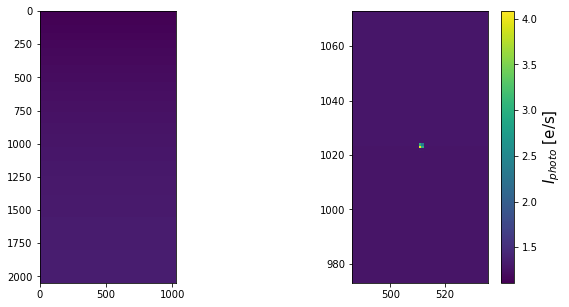

In [32]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

xpix_int, ypix_int = int(xpos/oversample), int(ypos/oversample)

_ = ax[0].imshow(spherex_image.data, interpolation='none')

im1 = ax[1].imshow(spherex_image.data, interpolation='none')
_ = ax[1].set_xlim(xpix_int-25, xpix_int+25)
_ = ax[1].set_ylim(ypix_int-50, ypix_int+50)
plt.colorbar(im1, ax=ax[1], label='$I_{photo}$ [e/s]')

### Convert to a count image [e-]

In [33]:
t_samp = 1.5
n_samp = 100
t_int = n_samp * t_samp
spherex_cnt = spherex_image * t_int

### Add noise

In [34]:
def get_noise_map(spherex_cnt, bandinfo=None):
    # Read noise
    sigma_CDS = 12.5  # [e]
    sigma_read = sigma_CDS * np.sqrt(6.0 / n_samp)

    # Dark_current - ignore in this example
    I_dark = 0.01

    # Use Gaussian instead of full Poisson noise
    varimg = spherex_cnt
    noise_map = ( np.random.normal(size=spherex_cnt.shape) * np.sqrt(varimg) +
                  np.random.normal(size=spherex_cnt.shape) * sigma_read )

    return noise_map

In [35]:
noise_map = get_noise_map(spherex_cnt, bandinfo=bandinfo)
spherex_cnt += noise_map

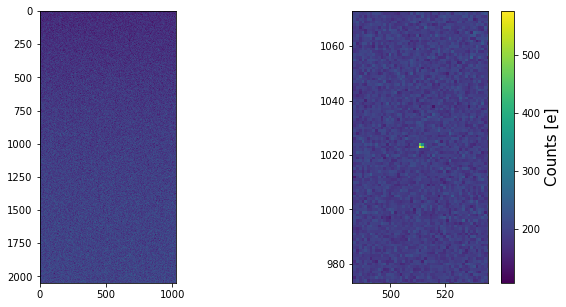

In [36]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

xpix_int, ypix_int = int(xpos/oversample), int(ypos/oversample)

_ = ax[0].imshow(spherex_cnt.data, interpolation='none')

im1 = ax[1].imshow(spherex_cnt.data, interpolation='none')
_ = ax[1].set_xlim(xpix_int-25, xpix_int+25)
_ = ax[1].set_ylim(ypix_int-50, ypix_int+50)
plt.colorbar(im1, ax=ax[1], label='Counts [e]')

In [37]:
header = spherex_wcs.to_header()                         # astropy.io.fits.Header
hdu = fits.PrimaryHDU(spherex_cnt, header=header)
hdu.writeto('spherex_sim.fits', overwrite=True)

## 5. Put everything together!

In [38]:
# Choose a band
band = 1

bandinfo = {
    'band': band,
    'lmin': lambda_min[band-1],
    'lmax': lambda_max[band-1],
    'R': resolving_power[band-1],
    'eff_LVF': eff_opt[band-1],
    'eff_total': eff_total[band-1],
}

In [39]:
# Select a pointing
ra_center, dec_center = 150.06890, 2.20573
oversample = 5
highres_image, highres_wcs = spherex_highres_image(ra_center, dec_center, oversample=oversample)

In [40]:
# Background map
wavemap = get_wavemap(bandinfo=bandinfo)
nuInu_zodi = nuInu_ZL(wavemap, f_ZL=2.0)
image_zodi = get_countrate_for_nuInu(nuInu_zodi, wavemap, bandinfo=bandinfo)

In [41]:
# Add sources
T = load_catalog(highres_wcs)

for r in T:
    ra, dec = r['ra'], r['dec']
    sedfile = r['sedfile']
    wave, flux = get_sed(sedfile)
    
    # Detector position
    xpos, ypos = get_pixel_coordinates(ra, dec, highres_wcs)

    # LVF
    xpix, ypix = xpos/oversample, ypos/oversample
    wave_lvf, trans_lvf = get_lvf_trans(xpix, ypix, bandinfo=bandinfo)

    # Source flux
    fnu_src = synth_phot(wave, flux, wave_lvf, trans_lvf, tol=1e-3) * 1e-6
    fnu_src *= 100

    # Inject 
    xpos_int, ypos_int = map(int, (xpos, ypos))
    highres_image <<= u.electron / u.s
    highres_image[ypos_int, xpos_int] = get_countrate_for_fnu(fnu_src, bandinfo=bandinfo)

# PSF convolution
lambda_cen = (bandinfo['lmin'] + bandinfo['lmax'])/2
kernel = get_psf(lambda_cen)
highres_image_conv = fftconvolve(highres_image, kernel, mode='same')

# Downsample
spherex_image, spherex_wcs = downsample(highres_image_conv, highres_wcs)

# Add background
spherex_image += image_zodi.data

# To counts
t_samp, n_samp = 1.5, 100
t_int = n_samp * t_samp
spherex_cnt = spherex_image * t_int

# Add noise
noise_map = get_noise_map(spherex_cnt, bandinfo=bandinfo)
spherex_cnt += noise_map

In [42]:
# Save
# ELCOSMOS_v1.part.reg
hdu = fits.PrimaryHDU(spherex_cnt, header=spherex_wcs.to_header())
hdu.writeto('spherex_sim_cosmos.fits', overwrite=True)